In [ ]:
import os
import gzip

import pandas as pd
import numpy as np
import scipy as sp

from datetime import datetime, timedelta
from collections import namedtuple 
from itertools import groupby

import pyprind #pip install pyprind

import matplotlib
%matplotlib inline
%alias_magic t timeit

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Tips to handle datasets larger then memory
- use iterators, never materialize whole set completely in memory
- use map, filter, ... and other functools 
- filter: https://docs.python.org/3.4/library/functions.html?highlight=filter#filter
- itertools: https://docs.python.org/3.4/library/itertools.html#module-itertools
- for experiments use only partial dataset, let full experiment run over night

# Loading data

load_data accepts a gziped file. Uncompression is done on the fly.
btw: load_data returns an iterator. always when you call next(load_data), the next item is yielded from the iterator. Be careful when passing it around. With list(it_load_data(file.gz)) you can materialize the iterator in memory. You can find more information here: https://docs.python.org/3.4/glossary.html#term-iterator

Uncompressed Household: 1G, compressed (gzip -9): 96M

# Setup
In the following Cell some namedtuples are defined, [Namedtuples](https://docs.python.org/3.4/library/collections.html#collections.namedtuple) are a lazy way to define classes 

adapt the sourcefile variable to the directory where you put the provided dataset

In [ ]:
Measurement = namedtuple('Measurement', ['ts', 'sid', 'load'])
PredictionBase = namedtuple('PredictionBase', ['base', 'actuals', 'slicemin', 'increment', 'currenttime'])
ForecastResult = namedtuple('ForecastResult', ['ts', 'actual', 'predicted'])

sourcefile = 'data/household.csv.gz'

In [ ]:
def it_load_data(filename):
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        header = f.readline() #ts,hh234,load
        ts, sensor, load = header.split(',')
        
        for line in f:
            date_str, sensorid_str, load_str = line.strip('\r\n').split(',')
            yield Measurement(datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S'), sensorid_str.strip(), int(load_str))

def it_take(num, it):
    """
    Returns an iterator which stops after num received items
    Displays a pyprind progress bar
    """
    bar = None
    for i in range(num):
        if bar is None:
            bar = pyprind.ProgBar(num)
            
        yield next(it)
        bar.update()


The code above has some helper functions you might want to use.
By convention, each function which begins with _it_ returns an iterator. With list(iterator()) a function can be materialized.
The cell below shows the first 4 measurements

In [ ]:
household_data_samples = list(it_take(4, it_load_data(sourcefile)))
household_data_samples

# Timeseries prediction
The main idea of timeseries prediction is to take n length of history (e.g. 30 minutes) to predict what will happen in the next n minutes of future.

## Training and evaluation
We need to create a training set and a evaluation set. To train we can take as much historic data as possible to predict the future. In many cases we don't have enough history, also there could be other reasons, e.g. seasonal changes, which would effect the prediction algorithms. Hence in most cases we want to limit the length of history, e.g., 1 month. Machine learning algorithms need a lot of data. We use a simple trick to create more training points from history. We take every increment (e.g., 5min) the last slicemin (e.g. 30 min) to predict the future.



In [ ]:
def it_timeslices(it_measurements, slicemin, increment):
    def calc_initial(first, slicemin):
        temp = datetime(first.ts.year, first.ts.month, first.ts.day, first.ts.hour, first.ts.minute)
        rs = first.ts.minute % (slicemin * 2)
        return temp + timedelta(minutes=((slicemin*2) - rs))

    timeslice = list()

    first = it_measurements.__next__()
    timeslice.append(first)
    next_ts = calc_initial(first, slicemin)

    for meas in it_measurements:
        timeslice.append(meas)
        while meas.ts >= next_ts: #maybe we left out something and there are intermediate steps ...
            predictionbase_begin = next_ts - timedelta(minutes=(slicemin*2))
            predictionbase_end = next_ts - timedelta(minutes=slicemin)

            learn_base = list()
            forecast_base = list()
            cnt = 0

            for meas in timeslice:
                if not meas.ts >= predictionbase_begin:
                    cnt += 1
                else:
                    if meas.ts < predictionbase_end:
                        learn_base.append(meas)
                    elif meas.ts < next_ts:
                        forecast_base.append(meas)

            timeslice = timeslice[cnt:]
            curr = next_ts
            next_ts = next_ts + timedelta(minutes=increment)

            yield PredictionBase(learn_base, forecast_base, slicemin, increment, (curr - timedelta(minutes=slicemin)))

# Display data
The column below gets the first 10 slices, 15 min long, every 15 min one slice
The datframe displayes from the prediction base the first 10 lines


In [ ]:
itslice = it_timeslices(it_load_data(sourcefile), 15, 15)
df = pd.DataFrame(next(itslice).actuals, columns=Measurement._fields)
#df[df["sid"] == "s18"]
df

# Feature extraction for machine learning

We need to extract features from the prediction base and try to predict a target

In [ ]:
def calc_average_load(measures):
    #The reason why we do this so complicated is that sometimes a single sensor does not send data that often
    sorted_measures = sorted(measures, key=lambda meas: meas.sid)
    load_per_device = groupby(sorted_measures, key=lambda meas: meas.sid)
    
    def get_avg_load_of_device():
        for key, gmeasures in load_per_device:
            mean = np.mean(list(map(lambda meas: meas.load, gmeasures)))
            yield mean
            
    return np.sum(list(get_avg_load_of_device()))

from scipy.stats import kurtosis,skew

def extract_features(pb):
    dc = dict()
    dc.update({"hour": pb.currenttime.hour})
    dc.update({"avg": calc_average_load(pb.base)})
    #you can try to add additional features, e.g., last consumption?
    sorted_base = sorted(pb.base, key=lambda meas: meas.ts)
    max_ts = np.amax(list(map(lambda a: a.ts, sorted_base)))
    
    load_per_time = groupby(sorted_base, key=lambda meas: meas.ts)
    avgs_by_time = []
    for key, gmeasures in load_per_time:
        l_measures = list(gmeasures)
        list_loads = list(map(lambda a: a.load, l_measures))
        avgs_by_time.append(np.mean(list_loads))
        
        if key == max_ts:    
            dc.update({"last": np.mean(list_loads)})
    
    dc.update({"kurtosis": kurtosis(avgs_by_time)})
    dc.update({"skew": skew(avgs_by_time)})
    #print(sorted_base)
    #dc.update({"last_cons": np.sum(list(map(lambda a: a.load, list(load_per_time[len(list(load_per_time)) - 1]) )))}) #new feature

    
    sorted_base = sorted(pb.base, key=lambda meas: meas.sid)
    load_per_device = groupby(sorted_base, key=lambda meas: meas.sid)
    
    for key, gmeasures in load_per_device:
        l_measures = list(gmeasures)
        list_loads = list(map(lambda a: a.load, l_measures))
        dc.update({key + "_last": float(l_measures[len(l_measures)-1].load)})
        dc.update({key + "_stdev": np.std(list_loads)})
        dc.update({key + "_max": np.amax(list_loads)}) #new feature
        dc.update({key + "_mean": np.mean(list_loads)}) #new feature
        dc.update({key + "_kurtosis": kurtosis(list_loads)}) #new feature
        dc.update({key + "_skew": skew(list_loads)}) #new feature
    
    dc.update(target=calc_average_load(pb.actuals))
    dc.update({'target_disc': 0})
    return dc


def to_ml_dataset(listdict, discrete):
    df = pd.DataFrame(listdict)
    tokeep, todrop = 'target_disc', 'target'
    if not discrete:
        tokeep, todrop = todrop, tokeep
        
    tmp = df.drop([todrop, tokeep], 1)
    valvs = tmp.as_matrix()
    target = df[tokeep].values
    return np.nan_to_num(valvs), np.nan_to_num(target)


# Feature extraction
The cell below shows some extracted features.

Which other features would be helpful?

In [ ]:
def slice_plus_history(it):
    history = list()
    for sli in it:
        history.append(sli)
        if(len(history) > 672):
            yield sli, history[0]
            history = history[1:]
        

In [ ]:
itslice = it_timeslices(it_load_data(sourcefile), 15, 15)
first_ten_extracted = list(it_take(10, map(extract_features, itslice)))
df = pd.DataFrame(first_ten_extracted)
df

# Discretization

Some machine learning algorithms cannot deal with continous values, hence we have to discretize upfront. There is a huge number of potential ways to discretize load.

KMeans needs a number of 'clusters', e.g., it should create 5 clusters
The result is put in the column target_disc

In [ ]:
from scipy import stats
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import mixture

def discretize_target(n_clusters, list_of_features):
    targets = list(map(lambda f: f['target'], list_of_features))
    targets_arr = np.array(targets, dtype=np.float).reshape(-1, 1)
    
    #You could try a different cluster algorithm here
    #km = KMeans(n_clusters = n_clusters)   #little slower then Mini b # 28% MAPE
    #km = MiniBatchKMeans(n_clusters = n_clusters)# 28%
    km = mixture.GaussianMixture(n_components=n_clusters,covariance_type="full") # this gives the best results
    # however we are not using this discretization in the last configuration
    km.fit(targets_arr)
    
    for feature in list_of_features:
        feature['target_disc'] = km.predict(feature['target'])[0]
    
    return km

def undiscretize_target(km, value):
    #return km.cluster_centers_[value][0]
    return km.means_[value][0]
    

In [ ]:
centroids = discretize_target(3, first_ten_extracted)
pd.DataFrame(first_ten_extracted)

In [ ]:
def calculate_persistence(historylength_days, it_slices, minutes, increment, shoulddiscretize=True):
    historyslices = historylength_days*24*60/increment
    skipintermediate = np.ceil(minutes/increment)
    training_historic = list()
    intermediate = list()
    
    one_day_holder = 0
    pred_count = False
    
    cnt = 0
    for sli in it_slices:
        cnt += 1
        
        temp_target = calc_average_load(sli.actuals) # no need to extract features
        intermediate.insert(0, temp_target) #we don't want any overlap of historic and prediction data
        if len(intermediate) > skipintermediate: 
            training_historic.insert(0, intermediate.pop())
        
        if len(training_historic) > historyslices:
            training_historic.pop()
            
        if cnt > (historyslices + skipintermediate):            
            try:
                if not pred_count:
                    one_day_holder = temp_target
                    pred_count = True
                    last_price = training_historic[0]
                    yield ForecastResult(sli.currenttime, one_day_holder, last_price)
                    continue
                work_actual = temp_target
                predicted = one_day_holder
                one_day_holder = work_actual
                #print("this is work actual : " + str(work_actual))
                #print("this is predicted : " + str(predicted))
                #print("Done...")
                yield ForecastResult(sli.currenttime, work_actual, predicted)
            except Exception as e: 
                print("Error occured-continuing: " + str(e))
                pass

# Evaluation
The cell below shows how to evaluate the MAPE.
The version below also only consumes an iterator

In [ ]:
def eval_mape(results):
    cnt = 0
    sum = 0
    for f in results:
        cnt += 1
        sum += np.abs((f.actual - f.predicted) / f.actual)
    if cnt == 0:
        return np.nan
    else:
        return sum * 100 / cnt

In [ ]:
from math import sqrt
def nrmse(result_list):
    """
    Returns None if result_list is empty or squared sum of actual values is zero
    """
    error_sqr_sum = real_sqr_sum = 0
    n = len(result_list)
    if n == 0:
        return None
    for r in result_list:
        error_sqr_sum += (r.actual - r.predicted) ** 2
        real_sqr_sum  += r.actual ** 2
    num = sqrt(error_sqr_sum / n)
    denom = sqrt(real_sqr_sum / n)
    if denom == 0.0:
        return None # or set denom to 0.00001 ???
    return num / denom

In [ ]:
from sklearn import svm
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import mixture
from sklearn import tree
from sklearn import ensemble

def calculate_prediction(historylength_days, it_slices, minutes, increment,num_of_class, algorithm,shoulddiscretize=True):
    historyslices = historylength_days*24*60/increment
    skipintermediate = np.ceil(minutes/increment)
    training_historic = list()
    intermediate = list()
            
    cnt = 0
    for sli in it_slices:
        cnt += 1
        
        
        extracted_features = extract_features(sli)
        intermediate.insert(0, extracted_features) #we don't want any overlap of historic and prediction data
        if len(intermediate) > skipintermediate: 
            training_historic.insert(0, intermediate.pop())
        
        if len(training_historic) > historyslices:
            training_historic.pop()
            
        if cnt > (historyslices + skipintermediate):
            if shoulddiscretize: #The centroids can change over time, this is why rediscreize each time
                km = discretize_target(num_of_class, training_historic) #changed the discretize_target clusters
                            
            Xtrain, Ytrain = to_ml_dataset(training_historic, shoulddiscretize) #trainingset
            Xtest, Ytest = to_ml_dataset([extracted_features], shoulddiscretize) #predictionset
            
            
            try:
                #predictor = ensemble.AdaBoostRegressor(loss="square")
                
                clf = algorithm.fit(Xtrain, Ytrain) #actually training the machine learning algorithm
                predicted = clf.predict(Xtest)[0]
                if shoulddiscretize:
                    predicted = undiscretize_target(km, predicted)
                
                work_actual = extracted_features['target']
                yield ForecastResult(sli.currenttime, work_actual, predicted)
            except Exception as e: 
                print("Error occured-continuing: " + str(e))
                pass
                


In [ ]:
from sklearn import ensemble,tree
from sklearn import gaussian_process
from sklearn import kernel_ridge,svm
from sklearn import linear_model, neighbors,neural_network
solution_algo_ensemble = [
                 ensemble.ExtraTreesRegressor(),#49
                ensemble.GradientBoostingRegressor(),#50
                 ensemble.RandomForestRegressor(),#52
                ]
solution_algo_gaus = [
    gaussian_process.GaussianProcessRegressor(),#100
    
]
sol_alg_kernrig = [
    kernel_ridge.KernelRidge()#354
]
sol_lin_model = [
    linear_model.ARDRegression(),#90
    linear_model.BayesianRidge(), # 47 - 0.70
    linear_model.ElasticNet(), # 185 - 4
    linear_model.HuberRegressor(), # 43 - 0.76
    linear_model.Lars(), # worst ever
    linear_model.Lasso(),# 257 - 4
    linear_model.LassoLars(),# 63 - 0.80
    linear_model.LassoLarsIC(),# 51 - 0.66
    linear_model.LinearRegression(),# 1080 - 30
    linear_model.PassiveAggressiveRegressor(), # 75 - 0.93
    linear_model.RANSACRegressor(), # problem none...
    linear_model.Ridge(),# 423 - 10 
    linear_model.SGDRegressor(), # second worst
    linear_model.TheilSenRegressor() # 4000
]
sol_neigh = [
    neighbors.KNeighborsRegressor(), # 37 - 0.66
    neighbors.RadiusNeighborsRegressor(), # nan
]
sol_nn = [
    neural_network.MLPRegressor() # 70 - 0.90
]
sol_neigh_class = [
    neighbors.KNeighborsClassifier() # 56 - 0.87
]
sol_svm = [
    svm.LinearSVR(), # 92 - 1.28
    svm.NuSVR(), # 29 - 0.67
    svm.SVR(), # 27 - 0.68 # hor 200, 7, 50, --> 28 - 0.62
    #  svr continue 
    #  300 7 50  --> 32 - 0.57
    #  300 7 100 --> 32 - 0.56
    #  400 7 100 --> 32 - 0.50
    #  500 4 300 --> 32 - 0.47
    #  600 4 400 --> 31 - 0.42
    #  800 4 400 --> 29 - 0.39
    #  800 2 400 --> 28 - 0.38
    # 1000 2 400 --> 28 - 0.34    
    # 1000 2 600 --> 28 - 0.33    ---> 28 - 0.39 benchmark. ####   The best we have, but it is  so close to the benchmark
    # 1000 2 1000--> 34 - 0.38   ---> 37 - 0.45
    # 1200 2 1200--> 37 - 0.38   ---> 37 - 0.45
    #  600 2 600 --> 32 - 0.48  ---> 62 - 0.70
]
sol_tree = [
    tree.DecisionTreeRegressor(), # 57 - 0.80
    # 1000 2 600 --> 41 - 0.48
    tree.ExtraTreeRegressor() # 58 - 0.85
]

last_set =[
    linear_model.BayesianRidge(), #34 - 0.41
    linear_model.ElasticNet(), # 54 - 0.58
    linear_model.HuberRegressor(),#75 - 1.26
    linear_model.LassoLars(),# 63 - 0.80
    linear_model.LassoLarsIC(),
]
sol_alg = svm.SVR()

In [ ]:
horizon1 = 1000 
historylength1 = 2
increment1 = 600
num_discrete_class = 20 # as we are not discretizing this variable is unimportant 
discretize = False

In [53]:
def prediction_evaluation(horizon_and_predbase, historylength, increment, num_of_class,discretize,algorithm):
    evaluation_length = int(2 * 7 * 24 * 60 /increment)
    res_list = list(it_take(evaluation_length, calculate_prediction(historylength, it_timeslices(it_load_data(sourcefile), horizon_and_predbase, increment), horizon_and_predbase, increment,num_of_class,algorithm,discretize)))
    
    return eval_mape(res_list),nrmse(res_list), res_list

def benchmark_evaluation(horizon_and_predbase, historylength, increment, num_of_class,discretize,algorithm):
    evaluation_length = int(2 * 7 * 24 * 60 /increment)
    res_list = list(it_take(evaluation_length, calculate_persistence(historylength, it_timeslices(it_load_data(sourcefile), horizon_and_predbase, increment), horizon_and_predbase, increment)))
    return eval_mape(res_list),nrmse(res_list), res_list


#for sol_alg in last_set:
percent_mape,percent_nrmse,pred_results  = prediction_evaluation(horizon1, historylength1, increment1,num_discrete_class,discretize,sol_alg) #Evaluate [horizon1] ahead forecast, [historylength1] days of learning, every [increment1] minutes
print("The MAPE of the prediction was:", percent_mape)
print("The NRMSE of the prediction was:", percent_nrmse)
pred_results_df = pd.DataFrame(list(pred_results), columns=ForecastResult._fields)

# benchmark 
# 1000 2 1000 ---> 37 0.45

pred_results_df = pd.DataFrame(list(pred_results), columns=ForecastResult._fields)
percent_mape_bench,percent_nrmse_bench,bench_results  = benchmark_evaluation(horizon1, historylength1, increment1,num_discrete_class,discretize,sol_alg) #Evaluate [horizon1] ahead forecast, [historylength1] days of learning, every [increment1] minutes
print("The MAPE of the benchmark Persistence with same parameters was:", percent_mape_bench)
print("The NRMSE of the benchmark Persistence with same parameters was:", percent_nrmse_bench)

0% [##############################] 100% | ETA: 00:00:00

The MAPE of the prediction was: 28.979247966138264
The NRMSE of the prediction was: 0.33789355066234766



Total time elapsed: 00:02:48
0% [##############################] 100% | ETA: 00:00:00

The MAPE of the benchmark Persistence with same parameters was: 28.353271927496614
The NRMSE of the benchmark Persistence with same parameters was: 0.3904429135189475



Total time elapsed: 00:01:29


In [ ]:
#print(percent_mape_bench)
pred_results_df = pd.DataFrame(list(pred_results), columns=ForecastResult._fields)
#pred_results_df = pd.DataFrame(list(bench_results), columns=ForecastResult._fields)

33

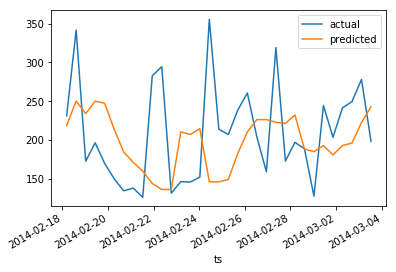

In [54]:
pred_results_df.set_index('ts').plot()
len(pred_results_df)